In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import shutil
import sys
import random
import pickle
import torch
import kornia
import mahotas
# import seaborn as sns

import matplotlib
from matplotlib import colors

from multiprocessing import Pool

PROJ_DIR = os.path.dirname(os.path.abspath('.'))
if PROJ_DIR not in sys.path:
    sys.path.append(PROJ_DIR)

from utils.layout_utils import mean_IU, mean_precision


#Increase matplotlib font
plt.rcParams.update({'font.size': 14})

In [2]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

## Restructure occupancy anticipation output

In [3]:
# occ_ant_dir = '/scratch/shantanu.singh/bev_models/output/occ_ant/smount2'

# scenes = set()
# for filename in os.listdir(occ_ant_dir):
#     scenes.add(filename.split('_')[0])
    
# print(scenes)

In [4]:
# for scene in scenes:
#     os.makedirs('/scratch/shantanu.singh/bev_models/output/occ_ant/' + scene, exist_ok=True)
    
# for filename in os.listdir(occ_ant_dir):
#     if os.path.isdir(filename):
#         continue
#     folder, new_filename = filename.split('_')
#     old_fp = os.path.join(occ_ant_dir, filename)
#     new_fp = '/scratch/shantanu.singh/bev_models/output/occ_ant/{}/{}'.format(folder, new_filename)
#     os.rename(old_fp, new_fp)

# Define IOU with radial weighting

In [5]:
bev_shape = (128, 128)
grid_indices = np.indices(bev_shape).transpose(1,2,0)
grid_dist = grid_indices - np.array([bev_shape[0], bev_shape[1]//2])
grid_normalized_dist = np.linalg.norm(grid_dist, axis=2) / np.sqrt(bev_shape[0]**2 + (bev_shape[1]//2)**2)

loss_mask = 1 - grid_normalized_dist

In [6]:
def check_size(eval_segm, gt_segm):
    h_e, w_e = segm_size(eval_segm)
    h_g, w_g = segm_size(gt_segm)

    if (h_e != h_g) or (w_e != w_g):
        raise EvalSegErr("DiffDim: Different dimensions of matrices!")


def segm_size(segm):
    try:
        height = segm.shape[0]
        width = segm.shape[1]
    except IndexError:
        raise

    return height, width


def extract_masks(segm, cl, n_cl):
    h, w = segm_size(segm)
    masks = np.zeros((n_cl, h, w))

    for i, c in enumerate(cl):
        masks[i, :, :] = segm == c

    return masks


def extract_both_masks(eval_segm, gt_segm, cl, n_cl):
    eval_mask = extract_masks(eval_segm, cl, n_cl)
    gt_mask = extract_masks(gt_segm, cl, n_cl)

    return eval_mask, gt_mask


def f1_score(eval_segm, gt_segm, n_cl):

    check_size(eval_segm, gt_segm)
    cl = np.arange(n_cl)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)
    f1score = [0] * n_cl
    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]
        n_ij = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))  # True positive
        n_ii = np.sum(np.logical_and(curr_eval_mask, 1 - curr_gt_mask))  # False positive
        n_jj = np.sum(np.logical_and(1 - curr_eval_mask, curr_gt_mask)) # False negative
        if np.sum(curr_gt_mask) + np.sum(curr_eval_mask) == 0:
            f1score[i] = 1
        else:
            f1score[i] = 2 * n_ij / (2 * n_ij + n_ii + n_jj)
    return f1score

def compute_ssim(gt, pred, window=3):
    gt = torch.unsqueeze(torch.unsqueeze(torch.Tensor(gt), dim=0), dim=0)
    pred = torch.unsqueeze(torch.unsqueeze(torch.Tensor(pred), dim=0), dim=0)

    ssim = kornia.metrics.ssim(gt, pred, window)
    return ssim.mean().cpu().numpy()


def cosine_sim(a, b):
    if np.linalg.norm(a) == 0 or np.linalg.norm(b) == 0:
        return 0
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim

def compute_zernike(gt, pred, radius=10):
    # GT = (128, 128)
    
    gt_mom = mahotas.features.zernike_moments(gt, radius)
    pred_mom = mahotas.features.zernike_moments(pred, radius)
    
    ans = cosine_sim(gt_mom, pred_mom)
    
    return ans

In [7]:
 ##General util function to get the boundary of a binary mask.
def mask_to_boundary(mask, dilation_ratio=0.02):
    """
    Convert binary mask to boundary mask.
    :param mask (numpy array, uint8): binary mask
    :param dilation_ratio (float): ratio to calculate dilation = dilation_ratio * image_diagonal
    :return: boundary mask (numpy array)
    """
    h, w = mask.shape
    img_diag = np.sqrt(h ** 2 + w ** 2)
    dilation = int(round(dilation_ratio * img_diag))
    if dilation < 1:
        dilation = 1
    # Pad image so mask truncated by the image border is also considered as boundary.
    new_mask = cv2.copyMakeBorder(mask, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0)
    kernel = np.ones((3, 3), dtype=np.uint8)
    new_mask_erode = cv2.erode(new_mask, kernel, iterations=dilation)
    mask_erode = new_mask_erode[1 : h + 1, 1 : w + 1]
    # G_d intersects G in the paper.
    return mask - mask_erode

def boundary_iou(gt, dt, dilation_ratio=0.02):
    """
    Compute boundary iou between two binary masks.
    :param gt (numpy array, uint8): binary mask
    :param dt (numpy array, uint8): binary mask
    :param dilation_ratio (float): ratio to calculate dilation = dilation_ratio * image_diagonal
    :return: boundary iou (float)
    """
    gt_boundary = mask_to_boundary(gt, dilation_ratio)
    dt_boundary = mask_to_boundary(dt, dilation_ratio)
    intersection = ((gt_boundary * dt_boundary) > 0).sum()
    union = ((gt_boundary + dt_boundary) > 0).sum()
    boundary_iou = intersection / union
    return boundary_iou

## Evaluation

In [28]:
model_output = dict()

# model_output["occant_rgb_vo"] = '/scratch/shantanu/results/occant_rgb_vo/dump/0/{}/0/pred_visible_occupancy/{}.png'
# model_output["ans_rgb_vo"] = '/scratch/shantanu/results/ans_rgb_vo/dump/0/{}/0/left_bevpred/{}.png'
# model_output["ans_rgb_vo41"] = '/scratch/shantanu/results/ans_rgb_vo41/dump/0/{}/0/left_bevpred/{}.png'
# model_output["ans_rgb_vo41_ep5"] = '/scratch/shantanu/results/ans_rgb_vo41_ep5/dump/0/{}/0/left_bevpred/{}.png'
# model_output["occant_rgb"] = '/scratch/shantanu/results_21022022/occant_rgb/dump/0/{}/0/left_bevpred/{}.png'
# model_output["occant_rgbd"] = '/scratch/shantanu/results/occant_rgbd/dump/0/{}/0/left_bevpred/{}.png'
# model_output["occant_depth"] = '/scratch/shantanu/results/occant_depth/dump/0/{}/0/left_bevpred/{}.png'
# model_output["occant_lstm"] = '/scratch/shantanu/results/occant_lstm/dump/0/{}/0/left_bevpred/{}.png'
# model_output["occant_concat"] = '/scratch/shantanu/results/occant_concat/dump/0/{}/0/left_bevpred/{}.png'
# model_output["occant_semantics"] = '/scratch/shantanu/results/occant_semantics/dump/0/{}/0/left_bevpred/{}.png'
# model_output["occant_auxsemantics"] = '/scratch/shantanu/results/occant_auxsemantics/dump/0/{}/0/left_bevpred/{}.png'

# model_output["depthraw"] = '/scratch/shantanu/results/depthraw/dump/0/{}/0/left_bevpred/{}.png'
# model_output["chandrakar"] = '/scratch/shantanu/results/chandrakar2/{}/0/pred_bev/{}.png'
# model_output["chandrakarbev"] = '/scratch/shantanu/results/chandrakarbev/dump/0/{}/0/left_bevpred/{}.png'
# model_output["chandrakardepth"] = '/scratch/shantanu/results/chandrakarbev/dump/0/{}/0/left_bevpred/{}.png'
# model_output["maskeddepth"] = '/scratch/shantanu/results/maskeddepth/dump/0/{}/0/left_bevpred/{}.png'
# model_output["crossview"] = '/scratch/shantanu/crossview/model_outputs/pred/{}/{}.png'

# model_output["chandrakr_bev"] = '/scratch/shantanu/gibson4/chandrakar_g4/{}/0/{}/pred_bev/{}.png'
# model_output["chandrakr_depth"] = '/scratch/shantanu/gibson4/chandrakar_g4/{}/0/{}/pred_depth/{}.png'
# model_output["ans_rgb"] = '/scratch/shantanu/results_24022022/ans_rgb/dump/0/{}/{}/bev_pred/{}.png'
# model_output["occant_rgb"] = '/scratch/shantanu/results_24022022/occant_rgb/dump/0/{}/{}/bev_pred/{}.png'
# model_output["occant_rgbd"] = '/scratch/shantanu/results_24022022/occant_rgbd/dump/0/{}/{}/bev_pred/{}.png'
# model_output["occant_ckdepth"] = '/scratch/shantanu/results_24022022/occant_ckdepth/dump/0/{}/{}/bev_pred/{}.png'
# model_output["occant_ckbev"] = '/scratch/shantanu/results_24022022/occant_ckbev/dump/0/{}/{}/bev_pred/{}.png'
# model_output["basic_transformer"] = '/scratch/shantanu/results_24022022/basic_transformer/{}/{}/{}.png'
# model_output["bt_ckdepth_preattn"] = '/scratch/shantanu/results_24022022/ckdepth_resnet/{}/{}/{}.png'

model_output["ans_rgb"] = '/scratch/shantanu/final_results/gibson4/ans_rgb/dump/0/{}/{}/bev_pred/{}.png'
model_output["occant_rgb"] = '/scratch/shantanu/final_results/gibson4/occant_rgb/dump/0/{}/{}/bev_pred/{}.png'
model_output["occant_rgbd"] = '/scratch/shantanu/final_results/gibson4/occant_rgbd/dump/0/{}/{}/bev_pred/{}.png'
model_output["basic_transformer"] = '/scratch/shantanu/final_results/gibson4/weights_90/{}/{}/{}.png'

In [8]:
# '/scratch/shantanu/gibson4/new/Adrian/0/front/RGB/'
# '/scratch/shantanu/gibson4/semantics/Adrian/0/front/semantics/'
# '/scratch/shantanu/gibson4/dilated_partialmaps/Adrian/front/partial_occ/0.png'
# '/scratch/shantanu/gibson4/visible_occupancy/Adrian/0/front/vo/0.png'
# '/scratch/shantanu/gibson4/chandrakar_g4/'

In [33]:
gt_rgb = '/scratch/shantanu/gibson4/new/{}/0/{}/RGB/{}.jpg'
gt_depth = '/scratch/shantanu/gibson4/new/{}/0/{}/DEPTH/{}.png'
# gt_semantics = '/scratch/shantanu/tiny_gibson/semantics/{}/0/{}/semantics/{}.png'
gt_bev = '/scratch/shantanu/gibson4/new/{}/0/{}/map/{}.png'
gt_po = '/scratch/shantanu/gibson4/dilated_partialmaps/{}/{}/partial_occ/{}.png'
# gt_vo = '/scratch/shantanu/tiny_gibson/visible_occupancy/{}/0/{}/vo/{}.png'

In [30]:
gt_rgb = '/scratch/pavani/mp3d/mp3d_output/{}/0/{}/RGB/{}.jpg'
gt_depth = '/scratch/pavani/mp3d/mp3d_output/{}/0/{}/DEPTH/{}.png'
gt_bev = '/scratch/pavani/mp3d/mp3d_output/{}/0/{}/map/{}.png'
gt_po = '/scratch/pavani/mp3d/mp3d_dilated_partialmaps/{}/{}/partial_occ/{}.png'

In [34]:
val_split_file = '../splits/gibson4/filtered_front_val_files.txt'
with open(val_split_file, 'r') as f:
    val_fps = f.read().splitlines()
    
val_fps[:5]

['Pablo front 0',
 'Pablo front 1',
 'Pablo front 2',
 'Pablo front 3',
 'Pablo front 4']

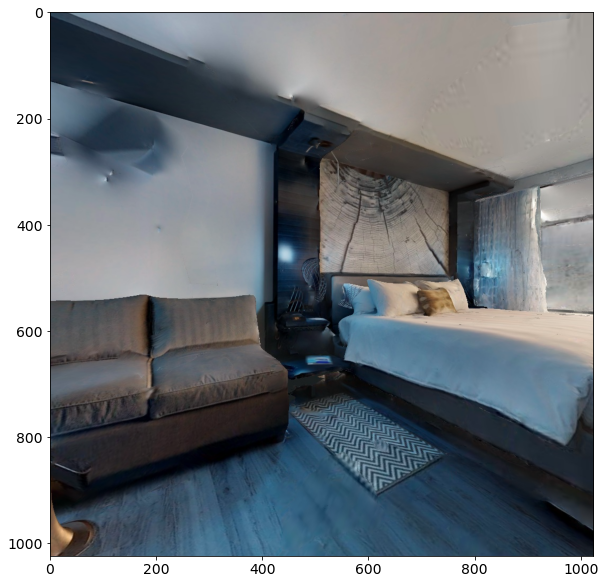

In [35]:
fig = plt.figure(figsize=(20, 10))

rgb_img = cv2.imread(gt_rgb.format(*val_fps[0].split()), -1)
plt.imshow(rgb_img)

### Qualitative

/scratch/shantanu/final_results/gibson4/ans_rgb/dump/0/Mosquito/front/bev_pred/96.png
/scratch/shantanu/final_results/gibson4/occant_rgb/dump/0/Mosquito/front/bev_pred/96.png
/scratch/shantanu/final_results/gibson4/occant_rgbd/dump/0/Mosquito/front/bev_pred/96.png
/scratch/shantanu/final_results/gibson4/weights_90/Mosquito/front/96.png


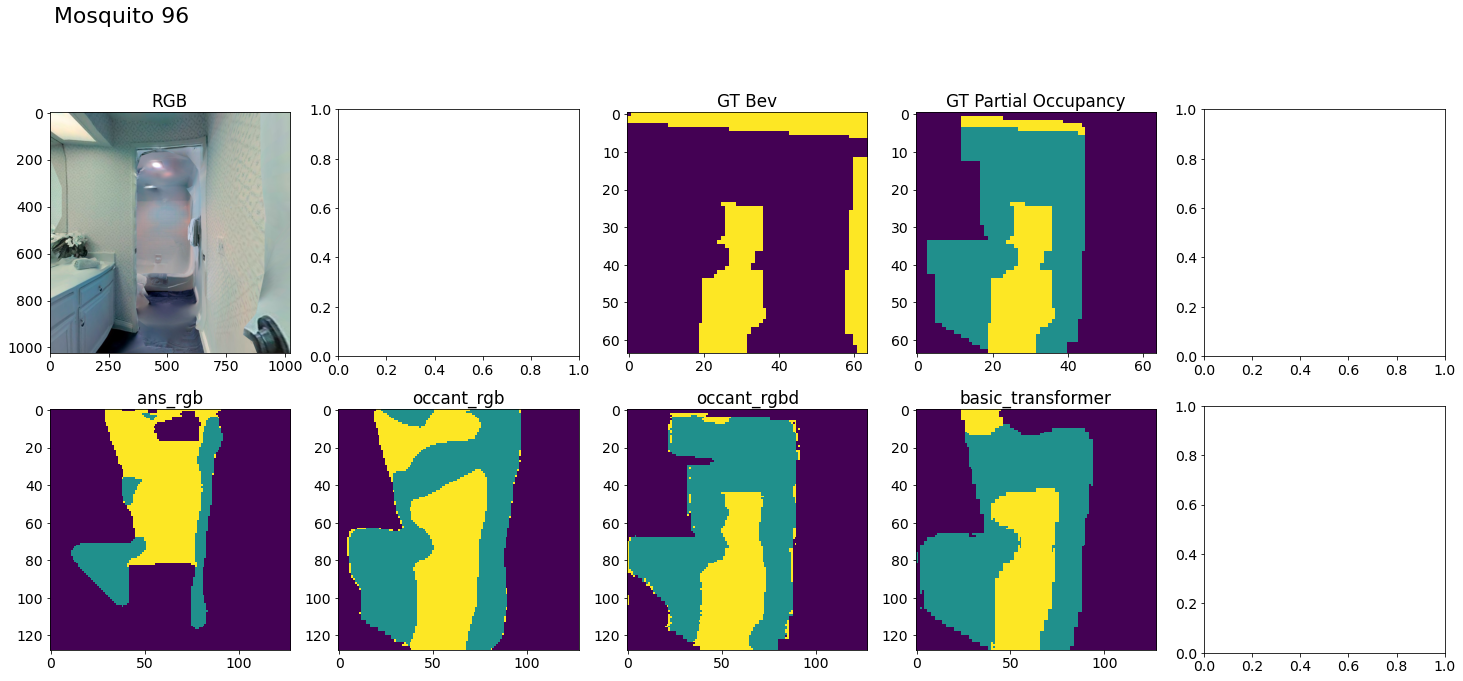

In [36]:
idx = np.random.randint(len(val_fps))

scene, pose, fileidx =  val_fps[idx].split() #'Wiconisco', 10
fileidx = int(fileidx)

# scene, pose, fileidx = 'Cantwell', 'front', 367

cmap = colors.ListedColormap(['k','b','y'])

ncols = max(len(model_output), 5)
fig, ax = plt.subplots(ncols=ncols, nrows=2, figsize=(5*ncols, 5*2))

rgb_fp = gt_rgb.format(scene, pose, fileidx)
rgb_img = cv2.imread(rgb_fp, -1)
ax[0][0].imshow(rgb_img)
ax[0][0].set_title('RGB')

# semantics_fp = gt_semantics.format(scene, pose, fileidx)
# print(semantics_fp)
# semantics_img = cv2.imread(semantics_fp, -1)
# print(semantics_img.shape)
# # To ensure consistent plotting, mark occupied as 127, free as 255, unknown as 0
# floor_semantics = (semantics_img == 3) * 255
# floor_semantics[floor_semantics == 0] = 127
# floor_semantics[0, 0] = 0
# # plot
# ax[0][1].imshow(floor_semantics, interpolation='nearest')
# ax[0][1].set_title('GT Floor Semantics')

gtbev_fp = gt_bev.format(scene, pose, fileidx)
gtbev_img = 255 - cv2.imread(gtbev_fp, -1)[64:, 32:96]
gtbev_img[0, 0] = 0
ax[0][2].imshow(gtbev_img)
ax[0][2].set_title('GT Bev')

gtpo_fp = gt_po.format(scene, pose, fileidx)
gtpo_img = cv2.imread(gtpo_fp, -1)[64:, 32:96]
gtpo_img[0, 0] = 0
ax[0][3].imshow(gtpo_img)
ax[0][3].set_title('GT Partial Occupancy')

# gtvo_fp = gt_vo.format(scene, pose, fileidx)
# gtvo_img = cv2.imread(gtvo_fp, -1)
# ax[0][4].imshow(gtvo_img)
# ax[0][4].set_title('GT Visible Occupancy')

for idx, model_name in enumerate(model_output):
    model_fp = model_output[model_name].format(scene, pose, fileidx)
    print(model_fp)
    model_img = cv2.imread(model_fp, -1)

    model_img[0, 0] = 0 # to ensure every image has zero label for plotting
        
    ax[1][idx].imshow(model_img, interpolation='nearest')
    ax[1][idx].set_title(model_name)
    
    
# fig.delaxes(ax[0][5])

plt.text(x=0.165, y=1, s=f"{scene} {fileidx}", fontsize=22, ha="center", transform=fig.transFigure)
plt.show()

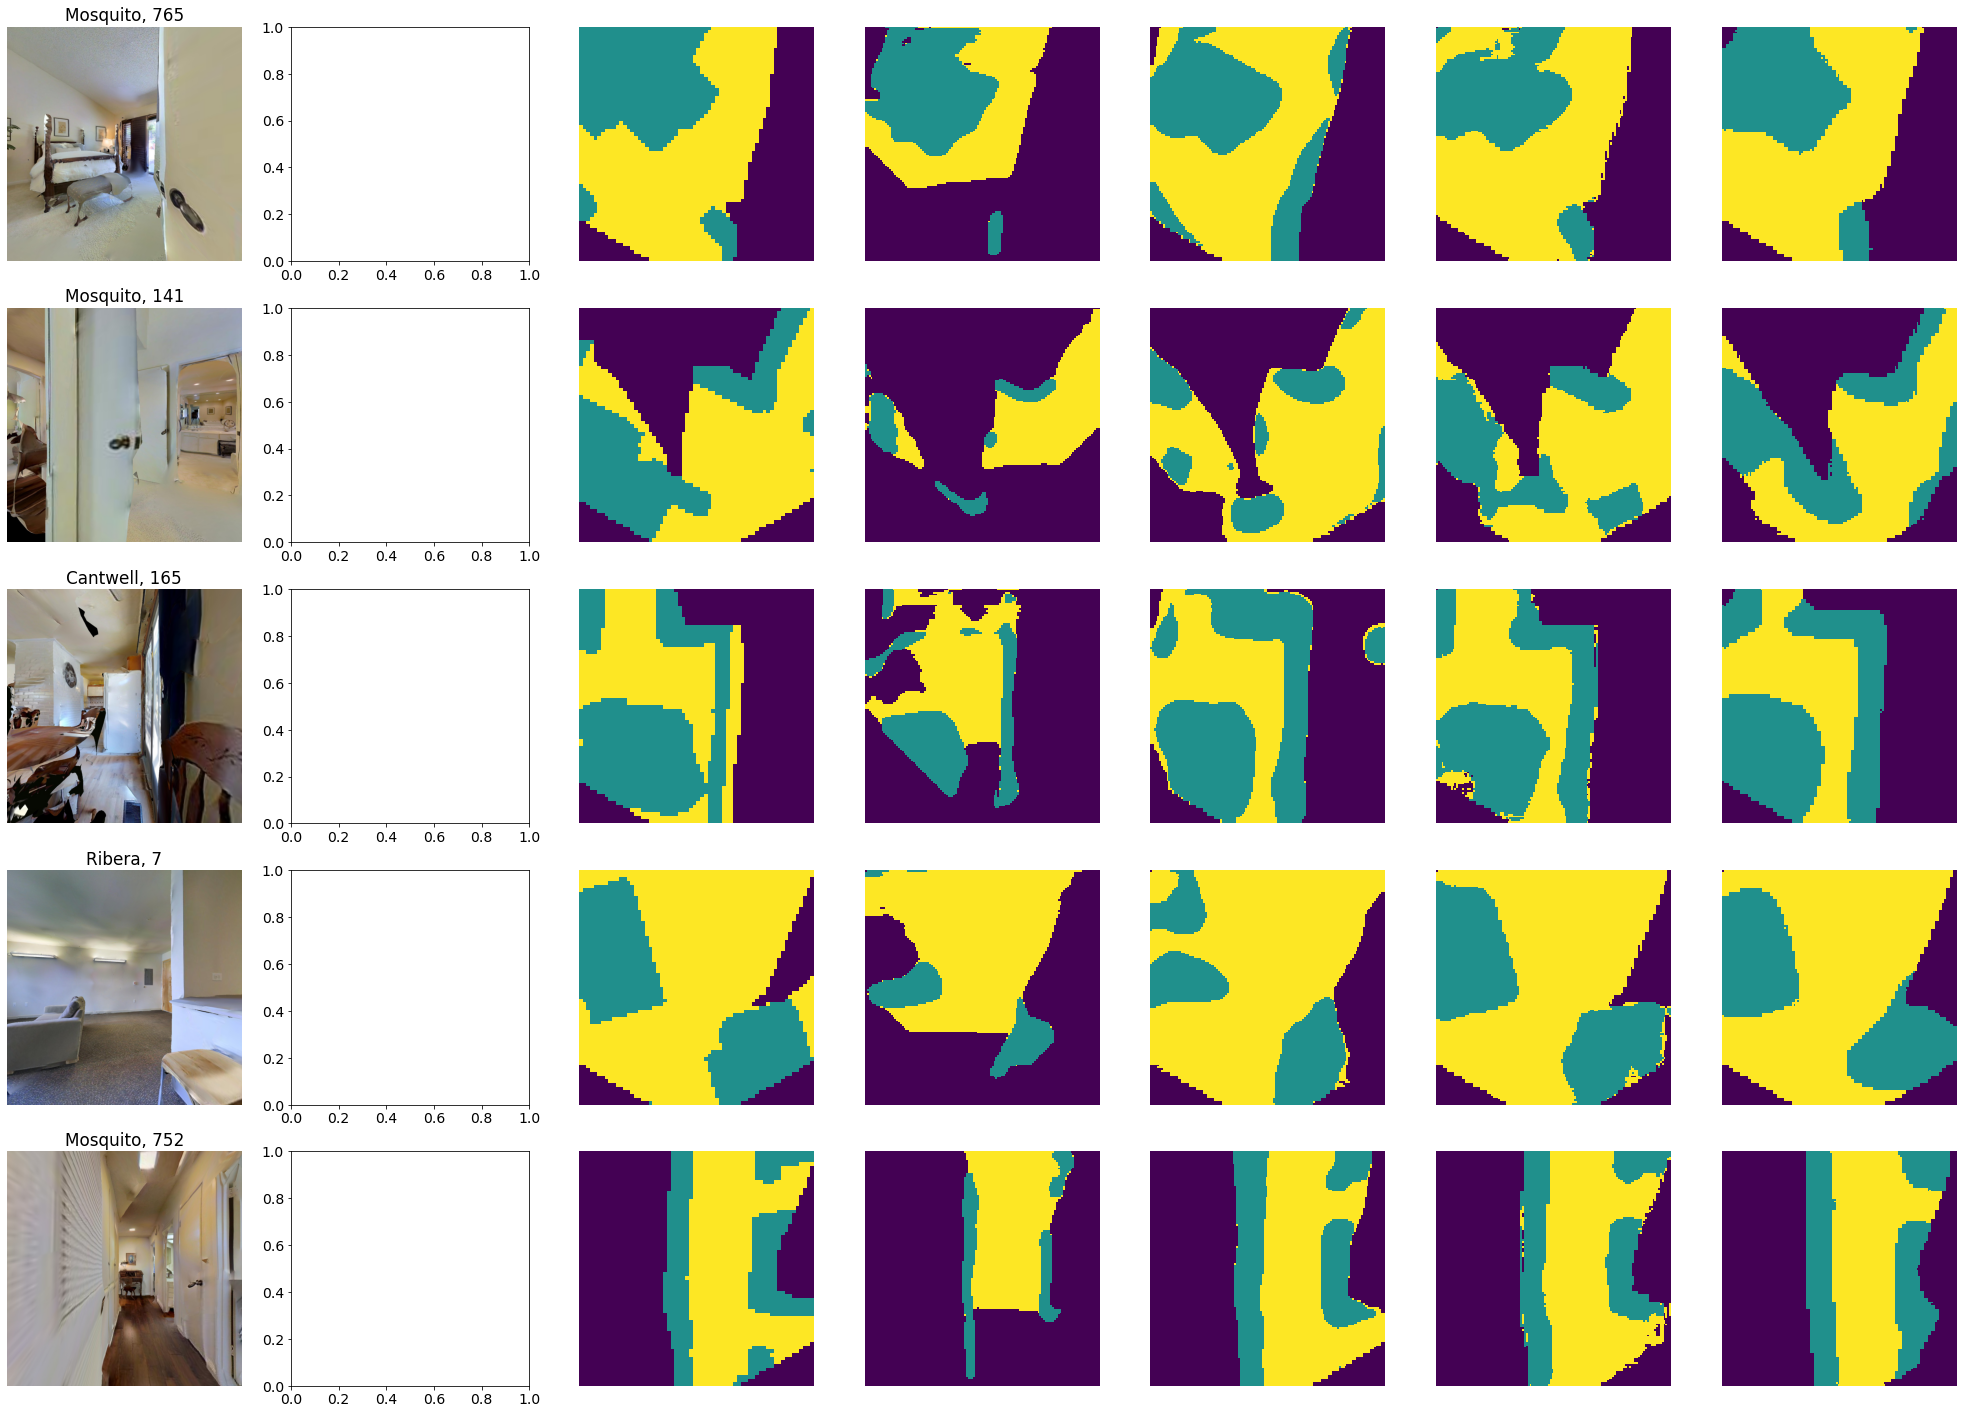

In [37]:
ncols = 3 + len(model_output)
nrows = 5
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5*ncols, 5*nrows))

random.shuffle(val_fps)

# val_fps = ['2azQ1b91cZZ front 929']

for row_idx in range(nrows):
    scene, pose, fileidx = val_fps[row_idx].split()

    rgb_fp = gt_rgb.format(scene, pose, fileidx)
    rgb_img = cv2.cvtColor(cv2.imread(rgb_fp, -1), cv2.COLOR_BGR2RGB)
    ax[row_idx][0].imshow(rgb_img)
    ax[row_idx][0].axis('off')
    ax[row_idx][0].set_title(f'{scene}, {fileidx}')

#     semantics_fp = gt_semantics.format(scene, pose, fileidx)
#     semantics_img = cv2.imread(semantics_fp, -1)
#     # To ensure consistent plotting, mark occupied as 127, free as 255, unknown as 0
#     floor_semantics = (semantics_img == 3) * 255
#     floor_semantics[floor_semantics == 0] = 127
#     floor_semantics[0, 0] = 0
#     floor_semantics[1, 0] = 127
#     floor_semantics[2, 0] = 255
#     # plot
#     ax[row_idx][1].imshow(floor_semantics, interpolation='nearest')
#     ax[row_idx][1].set_title('GT Floor Semantics')

    tgtbev_fp = gt_po.format(scene, pose, fileidx)
    tgtbev_img = cv2.imread(tgtbev_fp, -1)[64:, 32:96]
    gtbev_img[0, 0] = 0
    ax[row_idx][2].imshow(tgtbev_img)
    ax[row_idx][2].axis('off')
#     ax[row_idx][2].set_title('TGT Bev')

    # bev_fp = proj_bev.format(scene, fileidx)
    # bev_img = cv2.imread(bev_fp, -1)
    # ax[0][3].imshow(bev_img)
    # ax[0][3].set_title('Projected Bev')

    for idx, model_name in enumerate(model_output):
        model_fp = model_output[model_name].format(scene, pose, fileidx)
        model_img = cv2.imread(model_fp, -1)
        
        # Map 0 (Unknown) -> 127 to be consistent with GT Bev
        if model_name in ['Occupancy Anticipation']:
            model_img[model_img == 0] = 127

        model_img[0, 0] = 0 # to ensure every image has zero label for plotting

        ax[row_idx][3+idx].imshow(model_img, interpolation='nearest')
        ax[row_idx][3+idx].axis('off')
#         ax[row_idx][3+idx].set_title(model_name)
    
plt.show()

### Quantitative

In [50]:
model_names = list(model_output.keys())
if 'chandrakr_depth' in model_names:
    model_names.pop(model_names.index('chandrakr_depth'))

In [51]:
def calc_metric(paths):
    
    bev_size = (128, 128)
    
    tgtbev_fp, model_fp = paths.split()
    
    # 0 -> unknown, 1 -> occupied, 2 -> free
    tgtbev_img = cv2.imread(tgtbev_fp, -1)[64:, 32:96]
    tgtbev_img = cv2.resize(tgtbev_img, dsize=bev_size, interpolation=cv2.INTER_NEAREST)
    tgtbev_img = tgtbev_img // 127 
    
    model_img = cv2.imread(model_fp, -1).astype(np.uint8)
    model_img = cv2.resize(model_img, dsize=bev_size, interpolation=cv2.INTER_NEAREST)
    model_img = model_img // 127

    iou = mean_IU(model_img, tgtbev_img, 3)
    mAP = mean_precision(model_img, tgtbev_img, 3)
    f1 = f1_score(model_img, tgtbev_img, 3)
    ssim = [compute_ssim(model_img, tgtbev_img, 7).item(), 0, 0] 
    bIOU = [boundary_iou(model_img, tgtbev_img), 0, 0]
        
    return [iou, mAP, f1, ssim, bIOU]

In [52]:
def get_model_metrics(model_fp):
    process_args = []
    for fp in val_fps:
        scene, pose, fileidx = fp.split()
        exist_check = os.path.exists(model_fp.format(scene, pose, fileidx))
        if not exist_check:
            continue
        process_args.append('{} {}'.format(gt_po.format(scene, pose, fileidx), model_fp.format(scene, pose, fileidx)))

    with Pool(processes=10) as pool:
        results = pool.map(calc_metric, process_args)   
    
    return np.array(results).mean(axis=0)

In [53]:
model_scores = {}

for model_name, model_fp in model_output.items():
    model_scores[model_name] = get_model_metrics(model_fp)

In [54]:
with np.printoptions(precision=2, suppress=True): 
    for idx, metric in enumerate(['IOU', 'AP', 'F1', 'SSIM', 'B-IOU']):
        print(metric)
        for model_name, model_score in model_scores.items():
            print('\t', model_name, model_score[idx]*100)

IOU
	 ans_rgb [51.74 33.04 32.67]
	 occant_rgb [77.74 52.87 61.32]
	 occant_rgbd [87.03 69.63 71.54]
	 basic_transformer [81.2  57.83 64.85]
AP
	 ans_rgb [52.38 77.81 69.72]
	 occant_rgb [90.06 70.02 72.33]
	 occant_rgbd [94.93 83.01 81.02]
	 basic_transformer [91.39 70.92 78.67]
F1
	 ans_rgb [65.88 48.23 45.84]
	 occant_rgb [86.27 68.07 74.08]
	 occant_rgbd [92.38 81.5  82.15]
	 basic_transformer [88.66 72.3  76.94]
SSIM
	 ans_rgb [49.24  0.    0.  ]
	 occant_rgb [66.19  0.    0.  ]
	 occant_rgbd [74.75  0.    0.  ]
	 basic_transformer [69.38  0.    0.  ]
B-IOU
	 ans_rgb [14.65  0.    0.  ]
	 occant_rgb [36.43  0.    0.  ]
	 occant_rgbd [54.02  0.    0.  ]
	 basic_transformer [39.07  0.    0.  ]


In [49]:
# model_IU = dict([(k, []) for k in model_names])
# model_mAP = dict([(k, []) for k in model_names])
# model_f1 = dict([(k, []) for k in model_names])
# model_SSIM = dict([(k, []) for k in model_names])
# model_BIOU = dict([(k, []) for k in model_names])

# pct_inpainted = dict([(k, []) for k in model_names])
# inpaint_acc = dict([(k, []) for k in model_names])

# vr_acc = dict([(k, []) for k in model_names])

# bev_size = (128, 128)
# # model_names = list(model_output.keys())

# for fp in val_fps:
#     scene, pose, fileidx = fp.split()
    
#     # 0 -> unknown, 1 -> occupied, 2 -> free
#     tgtbev_fp = gt_po.format(scene, pose, fileidx)
#     tgtbev_img = cv2.imread(tgtbev_fp, -1)[64:, 32:96]
#     if tgtbev_img is None:
#         print("No TGT BEV for {}".format(tgtbev_fp))
#     tgtbev_img = cv2.resize(tgtbev_img, dsize=bev_size, interpolation=cv2.INTER_NEAREST)
#     tgtbev_img = tgtbev_img // 127 
    
# #     maskbev_fp = gt_vo.format(scene, pose, fileidx)
# #     maskbev_img = cv2.imread(maskbev_fp, -1)
# #     if tgtbev_img is None:
# #         print("No Mask BEV for {}".format(maskbev_fp))
# #     maskbev_img = cv2.resize(maskbev_img, dsize=bev_size, interpolation=cv2.INTER_NEAREST)
# #     maskbev_img = (maskbev_img // 127)
    
# #     tgtbev_img[maskbev_img] = 4
    
    
#     exist_check = [os.path.exists(model_output[model_name].format(scene, pose, fileidx)) for model_name in model_names]
#     if not np.all(exist_check):
#         print("Missing prediction for {}".format(fp))
#         print(np.array(model_names)[~np.array(exist_check)])
#         continue
    

#     for idx, model_name in enumerate(model_names):
#         model_fp = model_output[model_name].format(scene, pose, fileidx)
#         model_img = cv2.imread(model_fp, -1).astype(np.uint8)
#         model_img = cv2.resize(model_img, dsize=bev_size, interpolation=cv2.INTER_NEAREST)

#         if model_name in ['Occupancy Anticipation']:
#             model_img = model_img//255 + 1  # Other models follow 0 - occupied, 255 - freespace. Converting to our map
#         else:
#             model_img = model_img//127  # SCLnet predictions follow 0-unknown, 127-occupied, 254-freespace
            
# #         model_img[maskbev_img] = 4

# #         model_img[-20:, :] = 0
# #         maskbev_img[-20:, :] = 0
# #         tgtbev_img[-20:, :] = 0

#         model_IU[model_name].append(mean_IU(model_img, tgtbev_img, 3))
#         model_mAP[model_name].append(mean_precision(model_img, tgtbev_img, 3))
#         model_f1[model_name].append(f1_score(model_img, tgtbev_img, 3))
#         model_SSIM[model_name].append(compute_ssim(model_img, tgtbev_img, 7))
#         model_BIOU[model_name].append(boundary_iou(tgtbev_img, model_img))
# #         model_zernike[model_name].append(compute_zernike(model_img, tgtbev_img))
        
#         inpainted_pct = np.sum(np.logical_and(model_img != 0, maskbev_img  == 0)) /  (np.sum(maskbev_img  != 0) + 1e-6)
#         pct_inpainted[model_name].append(inpainted_pct)
        
#         inpaint_mask = np.logical_and(model_img != 0, maskbev_img  == 0)
#         if np.sum(inpaint_mask) == 0:
#             acc = 0
#         else:
#             acc = np.sum(model_img[inpaint_mask] == tgtbev_img[inpaint_mask]) / (np.sum(inpaint_mask) + 1e-6)
#         inpaint_acc[model_name].append(acc)
        
#         vr_acc[model_name].append(np.sum(model_img[maskbev_img!=0] == tgtbev_img[maskbev_img!=0]) / np.sum(maskbev_img!=0))

Missing prediction for Darden front 315
['ans_rgb' 'occant_rgb' 'occant_rgbd']


In [50]:
with np.printoptions(precision=2, suppress=True):
    for model_name, model_scores in model_IU.items():
        mean_score = np.mean(np.stack(model_scores), axis=0) * 100
        print(model_name, mean_score)

ans_rgb [48.63 29.21 36.  ]
occant_rgb [70.36 47.62 61.  ]
occant_rgbd [79.5  70.79 71.96]
basic_transformer [73.11 52.3  64.69]


In [51]:
with np.printoptions(precision=2, suppress=True):
    for model_name, model_scores in model_f1.items():
        mean_score = np.mean(np.stack(model_scores), axis=0) * 100
        print(model_name, mean_score)

ans_rgb [62.66 43.84 49.6 ]
occant_rgb [80.99 63.22 73.84]
occant_rgbd [87.18 82.36 82.24]
basic_transformer [83.1  67.53 76.94]


In [52]:
with np.printoptions(precision=2, suppress=True):
    for model_name, model_scores in model_mAP.items():
        mean_score = np.mean(np.stack(model_scores), axis=0) * 100
        print(model_name, mean_score)

ans_rgb [49.44 70.27 72.27]
occant_rgb [86.26 63.12 72.56]
occant_rgbd [90.08 85.45 80.5 ]
basic_transformer [87.92 64.13 77.8 ]


In [53]:
with np.printoptions(precision=2, suppress=True):
    for model_name, model_scores in model_SSIM.items():
        mean_score = np.mean(np.stack(model_scores), axis=0) * 100
        print(model_name, mean_score)

ans_rgb 47.99729883670807
occant_rgb 64.1645610332489
occant_rgbd 73.1998085975647
basic_transformer 66.45156145095825


In [54]:
with np.printoptions(precision=2, suppress=True):
    for model_name, model_scores in model_BIOU.items():
        mean_score = np.mean(np.stack(model_scores), axis=0) * 100
        print(model_name, mean_score)

ans_rgb 14.460872286317588
occant_rgb 33.164501476394214
occant_rgbd 51.25482494275012
basic_transformer 34.961632778121285


In [46]:
#### with np.printoptions(precision=2, suppress=True):
#     for model_name, model_scores in model_zernike.items():
#         mean_score = np.mean(np.stack(model_scores), axis=0) * 100
#         print(model_name, mean_score)

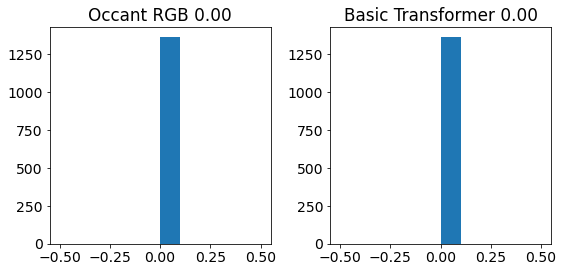

In [55]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
ax[0].hist(pct_inpainted['occant_rgb'])
ax[0].set_title('Occant RGB {:.2f}'.format(np.median(pct_inpainted['occant_rgb'])))
ax[1].hist(pct_inpainted['basic_transformer'])
ax[1].set_title('Basic Transformer {:.2f}'.format(np.median(pct_inpainted['basic_transformer'])))

# print('occant_rgb:{:.2f}   bt_ckdepth_preattn: {:.2f}'.format(np.median(pct_inpainted['occant_rgb']), 
#                                                              np.median(pct_inpainted['bt_ckdepth_preattn'])))

plt.tight_layout()
plt.show()

occant_rgb:0.67   basic_transformer: 0.71


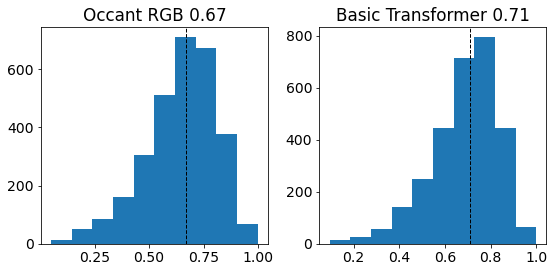

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
ax[0].hist(inpaint_acc['occant_rgb'])
ax[0].set_title('Occant RGB {:.2f}'.format(np.median(inpaint_acc['occant_rgb'])))
ax[0].axvline(np.median(inpaint_acc['occant_rgb']), color='k', linestyle='dashed', linewidth=1)
ax[1].hist(inpaint_acc['basic_transformer'])
ax[1].set_title('Basic Transformer {:.2f}'.format(np.median(inpaint_acc['basic_transformer'])))
ax[1].axvline(np.median(inpaint_acc['basic_transformer']), color='k', linestyle='dashed', linewidth=1)

print('occant_rgb:{:.2f}   basic_transformer: {:.2f}'.format(np.median(inpaint_acc['occant_rgb']), 
                                                             np.median(inpaint_acc['basic_transformer'])))
plt.tight_layout()
plt.show()

occant_rgb:0.83   basic_transformer: 0.85


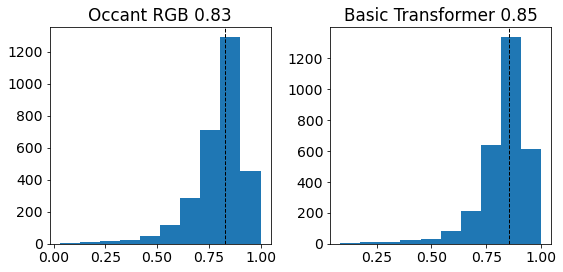

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
ax[0].hist(vr_acc['occant_rgb'])
ax[0].set_title('Occant RGB {:.2f}'.format(np.median(vr_acc['occant_rgb'])))
ax[0].axvline(np.median(vr_acc['occant_rgb']), color='k', linestyle='dashed', linewidth=1)
ax[1].hist(vr_acc['basic_transformer'])
ax[1].set_title('Basic Transformer {:.2f}'.format(np.median(vr_acc['basic_transformer'])))
ax[1].axvline(np.median(vr_acc['basic_transformer']), color='k', linestyle='dashed', linewidth=1)

print('occant_rgb:{:.2f}   basic_transformer: {:.2f}'.format(np.median(vr_acc['occant_rgb']), 
                                                             np.median(vr_acc['basic_transformer'])))
plt.tight_layout()
plt.show()

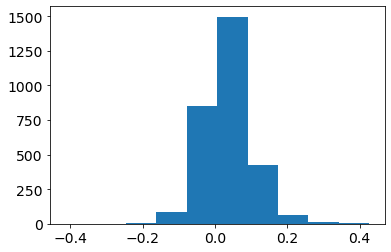

In [62]:
model_A = 'occant_rgb'
model_B = 'basic_transformer'

mean_row_f1 = lambda x: np.mean(np.stack(model_f1[x])[:,1:], axis=1)

modelA_scores = mean_row_f1(model_A)
modelB_scores = mean_row_f1(model_B)

diff_mean_f1 = modelB_scores - modelA_scores

plt.hist(diff_mean_f1)
plt.show()

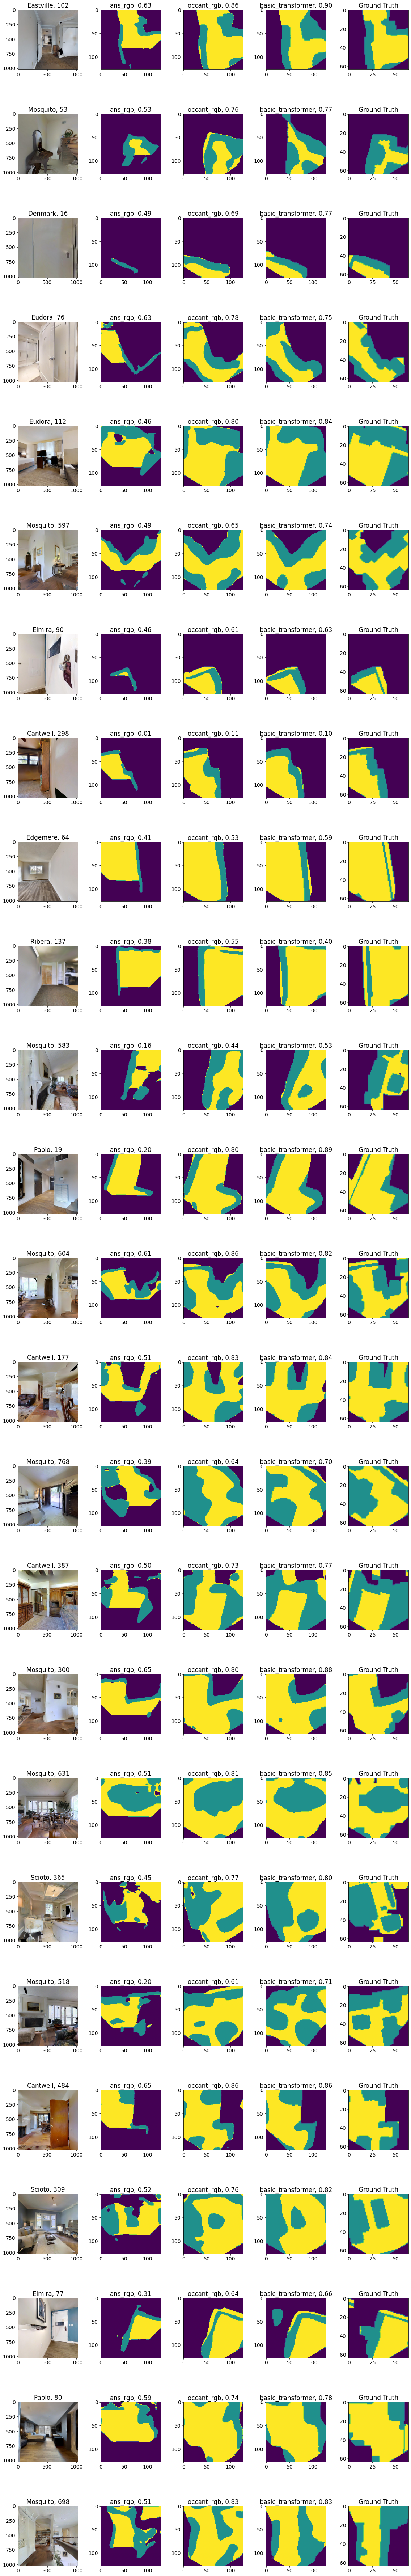

In [64]:
diff_mean_f1[diff_mean_f1 > 0.2] = 0
descending_ord = np.argsort(diff_mean_f1)


# descending_ord = np.argsort(-1 * np.array(pct_inpainted[model_B]) * np.array(inpaint_acc[model_B]))
descending_ord = np.arange(len(val_fps))
np.random.shuffle(descending_ord)

curr_idx = 2
nrows = 25
fig, ax = plt.subplots(ncols=5, nrows=nrows, figsize=(4*4, nrows*4))

other_scores = mean_row_f1('ans_rgb')

with np.printoptions(precision=2, suppress=True):
    for row_idx, idx in enumerate(descending_ord[curr_idx*nrows:(curr_idx+1)*nrows]):
        scene, pose, fileidx = val_fps[idx].split()

        rgb_fp = gt_rgb.format(scene, pose, fileidx)
        rgb_img = cv2.cvtColor(cv2.imread(rgb_fp, -1), cv2.COLOR_BGR2RGB)
        ax[row_idx][0].imshow(rgb_img)
        ax[row_idx][0].set_title(f'{scene}, {fileidx}')
        
        other_fp = model_output['ans_rgb'].format(scene, pose, fileidx)
        other_img = cv2.imread(other_fp, -1)
        other_img[0, 0] = 0
        ax[row_idx][1].imshow(other_img)
        ax[row_idx][1].set_title('{}, {:.2f}'.format('ans_rgb', other_scores[idx]))

        
        model_A_fp = model_output[model_A].format(scene, pose, fileidx)
        model_A_img = cv2.imread(model_A_fp, -1)
        model_A_img[0, 0] = 0
        ax[row_idx][2].imshow(model_A_img)
        ax[row_idx][2].set_title('{}, {:.2f}'.format(model_A, modelA_scores[idx]))
        
        model_B_fp = model_output[model_B].format(scene, pose, fileidx)
        model_B_img = cv2.imread(model_B_fp, -1)
        model_B_img[0, 0] = 0
        ax[row_idx][3].imshow(model_B_img)
        ax[row_idx][3].set_title('{}, {:.2f}'.format(model_B, modelB_scores[idx]))
        
        tgtbev_fp = gt_po.format(scene, pose, fileidx)
        tgtbev_img = cv2.imread(tgtbev_fp, -1)[64:, 32:96]
        gtbev_img[0, 0] = 0
        ax[row_idx][4].imshow(tgtbev_img)
        ax[row_idx][4].set_title('Ground Truth')
        
        
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

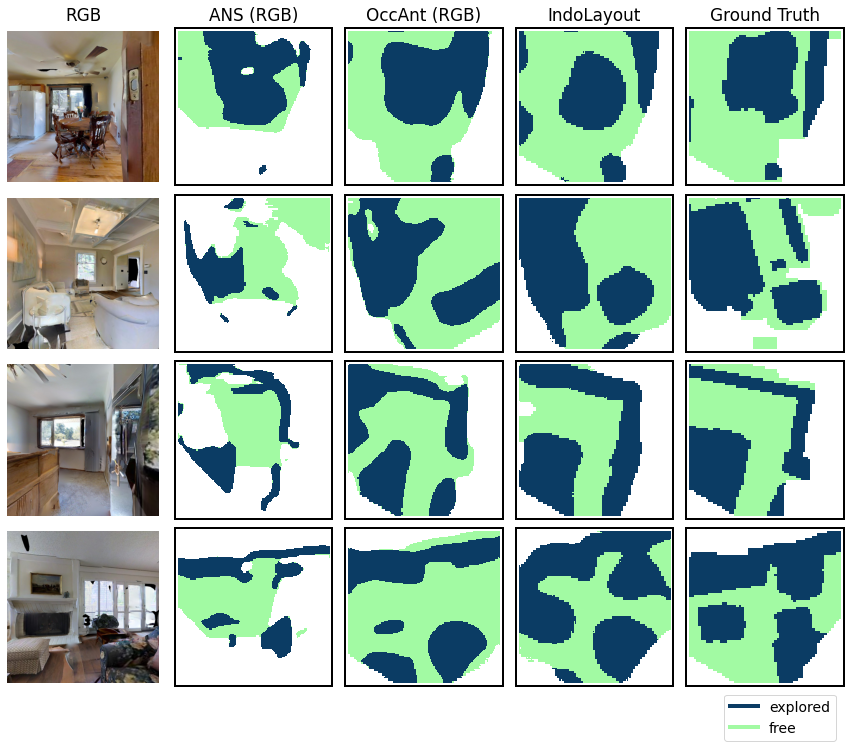

In [87]:
fig, ax = plt.subplots(ncols=5, nrows=4, figsize=(5*3, 4*3))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)
    
# paths = [
#     'Cantwell front 487',
#     'Mosquito front 536',
#     'Scioto front 365',
#     'Cantwell front 502'
# ]

paths = [
    'Cantwell front 487',
    'Scioto front 365',
    'Cantwell front 502',
    'Mosquito front 518'
]

clist = np.array([[255, 255, 255], [11, 60, 100], [162, 250, 163]])/255
cmap = matplotlib.colors.ListedColormap(clist)

def bbox_ax(ax):
    bbox = ax.get_tightbbox(fig.canvas.get_renderer())
    x0, y0, width, height = bbox.transformed(fig.transFigure.inverted()).bounds
    # slightly increase the very tight bounds:
    xpad = 0.02 * width
    ypad = 0.02 * height
    fig.add_artist(plt.Rectangle((x0-xpad, y0-ypad), width+2*xpad, height+2*ypad, edgecolor='black', linewidth=2, fill=False))
    

for row_idx, path in enumerate(paths):
        scene, pose, fileidx = path.split()

        rgb_fp = gt_rgb.format(scene, pose, fileidx)
        rgb_img = cv2.cvtColor(cv2.imread(rgb_fp, -1), cv2.COLOR_BGR2RGB)
        ax[row_idx][0].imshow(rgb_img)
        ax[row_idx][0].axis('off')
#         bbox_ax(ax[row_idx][0])
        
        other_fp = model_output['ans_rgb'].format(scene, pose, fileidx)
        other_img = cv2.imread(other_fp, -1)
        other_img[0, 0] = 0
        ax[row_idx][1].imshow(other_img, interpolation='nearest', cmap=cmap)
        ax[row_idx][1].axis('off')
        bbox_ax(ax[row_idx][1])

        
        model_A_fp = model_output[model_A].format(scene, pose, fileidx)
        model_A_img = cv2.imread(model_A_fp, -1)
        model_A_img[0, 0] = 0
        ax[row_idx][2].imshow(model_A_img, interpolation='nearest', cmap=cmap)
        ax[row_idx][2].axis('off')
        bbox_ax(ax[row_idx][2])
        
        model_B_fp = model_output[model_B].format(scene, pose, fileidx)
        model_B_img = cv2.imread(model_B_fp, -1)
        model_B_img[0, 0] = 0
        ax[row_idx][3].imshow(model_B_img, interpolation='nearest', cmap=cmap)
        ax[row_idx][3].axis('off')
        bbox_ax(ax[row_idx][3])
        
        tgtbev_fp = gt_po.format(scene, pose, fileidx)
        tgtbev_img = cv2.imread(tgtbev_fp, -1)[64:, 32:96]
        gtbev_img[0, 0] = 0
        ax[row_idx][4].imshow(tgtbev_img, interpolation='nearest', cmap=cmap)
        ax[row_idx][4].axis('off')
        bbox_ax(ax[row_idx][4])
        
        
        
tpad = 10
ax[0][0].set_title('RGB', pad=tpad)
ax[0][1].set_title('ANS (RGB)', pad=tpad)
ax[0][2].set_title('OccAnt (RGB)', pad=tpad)
ax[0][3].set_title('IndoLayout', pad=tpad)
ax[0][4].set_title('Ground Truth', pad=tpad)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=cmap(.5), lw=4),
                Line2D([0], [0], color=cmap(1.), lw=4)]

fig.legend(custom_lines, ['explored', 'free'], loc='lower right', bbox_to_anchor=(0.9,0.05))

        
fig.patch.set_facecolor('white')
plt.savefig('comparison.png', bbox_inches="tight")
plt.show()

In [58]:
# tgtdir = '../info/eval_results/gibson_tiny/28Feb2022'
# os.makedirs(tgtdir, exist_ok=True)
# pickle.dump(model_f1, open(f'{tgtdir}/f1.pkl', 'wb'))
# pickle.dump(model_IU, open(f'{tgtdir}/IU.pkl', 'wb'))
# pickle.dump(model_mAP, open(f'{tgtdir}/AP.pkl', 'wb'))
# pickle.dump(model_SSIM, open(f'{tgtdir}/SSIM.pkl', 'wb'))
# pickle.dump(model_BIOU, open(f'{tgtdir}/BIOU.pkl', 'wb'))

In [60]:
tgtdir = '../info/eval_results/gibson4/28Feb2022/'
model_f1 = pickle.load(open(f'{tgtdir}/f1.pkl', 'rb'))
model_IU = pickle.load(open(f'{tgtdir}/IU.pkl', 'rb'))
model_mAP = pickle.load(open(f'{tgtdir}/AP.pkl', 'rb'))
model_SSIM = pickle.load(open(f'{tgtdir}/SSIM.pkl', 'rb'))
model_BIOU = pickle.load(open(f'{tgtdir}/BIOU.pkl', 'rb'))

# Saliency Map

In [121]:
def bbox_ax(ax):
    bbox = ax.get_tightbbox(fig.canvas.get_renderer())
    x0, y0, width, height = bbox.transformed(fig.transFigure.inverted()).bounds
    # slightly increase the very tight bounds:
    xpad = 0.02 * width
    ypad = 0.02 * height
    fig.add_artist(plt.Rectangle((x0-xpad, y0-ypad), width+2*xpad, height+2*ypad, edgecolor='black', linewidth=2, fill=False))
    

In [57]:
front_saliency = '/scratch/shantanu/final_results/saliency_maps/bt_initial'
top_saliency = '/scratch/shantanu/final_results/saliency_maps/weights_90/Cantwell/front'

front_fps = ['{} {}'.format(scene, filename) for scene in os.listdir(front_saliency) 
             for filename in os.listdir(f'{front_saliency}/{scene}/front') 
             if os.path.isfile(f'{front_saliency}/{scene}/front/{filename}')]

top_fps = ['{} {}'.format(scene, filename) for scene in os.listdir(top_saliency) 
             for filename in os.listdir(f'{top_saliency}/{scene}/front') 
             if os.path.isfile(f'{top_saliency}/{scene}/front/{filename}')]

print(len(front_fps), len(top_fps))

common_fps = list(set(front_fps).intersection(set(top_fps)))
print(len(common_fps))

2955 2955
2955


In [77]:
! file '/scratch/shantanu/final_results/saliency_maps/weights_90/Cantwell/front/grad_rgb/free_8.png'

/scratch/shantanu/final_results/saliency_maps/weights_90/Cantwell/front/grad_rgb/free_8.png: PNG image data, 512 x 512, 8-bit/color RGB, non-interlaced


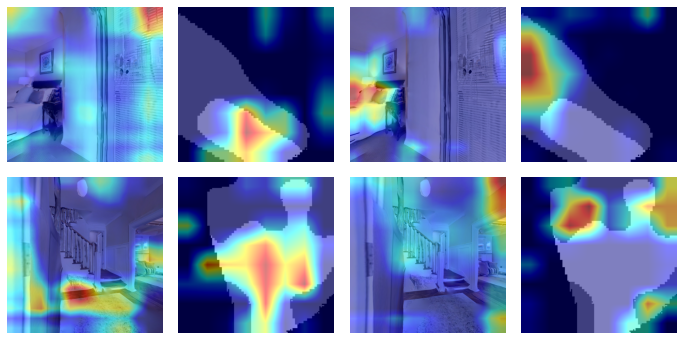

In [123]:
# fps = ['Cantwell 8', 'Mosquito 8']

fps = common_fps[:2]

states = ['free', 'occupied']

front_fp = '/scratch/shantanu/final_results/saliency_maps/bt_initial/{}/front/grad_rgb/{}_{}'
top_fp = '/scratch/shantanu/final_results/saliency_maps/weights_90/{}/front/grad_rgb/{}_{}'

fig, axarr = plt.subplots(ncols=4, nrows=len(fps), figsize=(len(fps)*6, 6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)

for idx, fp in enumerate(fps):
    scene, fileidx = fp.split()
    
    for state_idx, state in enumerate(states):
        per_path = front_fp.format(scene, state, fileidx)
        per_img = cv2.cvtColor(cv2.imread(per_path, -1), cv2.COLOR_BGR2RGB)
        
        top_path = top_fp.format(scene, state, fileidx)
        top_img = cv2.cvtColor(cv2.imread(top_path, -1), cv2.COLOR_BGR2RGB)
        
        axarr[idx][state_idx*2].imshow(per_img)
        axarr[idx][state_idx*2].axis('off')
        
        axarr[idx][state_idx*2 + 1].imshow(top_img)
        axarr[idx][state_idx*2 + 1].axis('off')
        
        
plt.show()

/scratch/shantanu/gibson4/new/Pablo/0/front/RGB/2.jpg /scratch/shantanu/final_results/saliency_maps/weights_90/Pablo/front/2.png


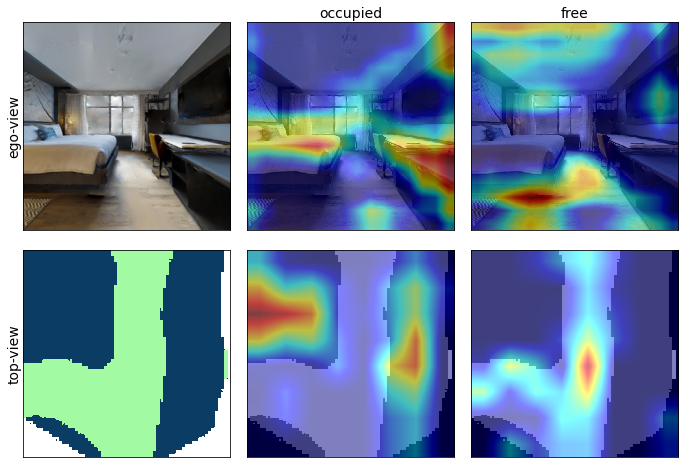

In [149]:
# fps = ['Cantwell 8', 'Mosquito 8']

clist = np.array([[255, 255, 255], [11, 60, 100], [162, 250, 163]])/255
cmap = matplotlib.colors.ListedColormap(clist)

fp = common_fps[77]  #55

states = ['occupied', 'free']

front_fp = '/scratch/shantanu/final_results/saliency_maps/bt_initial/{}/front/grad_rgb/{}_{}'
top_fp = '/scratch/shantanu/final_results/saliency_maps/weights_90/{}/front/grad_rgb/{}_{}'

fig, axarr = plt.subplots(ncols=3, nrows=2, figsize=(12,8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.01, hspace=0.1)

scene, fileidx = fp.split()

rgb_path = '/scratch/shantanu/gibson4/new/{}/0/front/RGB/{}'.format(scene, fileidx.replace('.png', '.jpg'))
bev_path = '/scratch/shantanu/final_results/saliency_maps/weights_90/{}/front/{}'.format(scene, fileidx)
print(rgb_path, bev_path)

rgb = cv2.cvtColor(cv2.imread(rgb_path, -1), cv2.COLOR_BGR2RGB)
bev = cv2.imread(bev_path, -1) // 127

axarr[0][0].imshow(rgb)
axarr[1][0].imshow(bev, cmap=cmap)
# axarr[0][0].axis('off')
# axarr[1][0].axis('off')

for state_idx, state in enumerate(states):
    per_path = front_fp.format(scene, state, fileidx)
    per_img = cv2.cvtColor(cv2.imread(per_path, -1), cv2.COLOR_BGR2RGB)

    top_path = top_fp.format(scene, state, fileidx)
    top_img = cv2.cvtColor(cv2.imread(top_path, -1), cv2.COLOR_BGR2RGB)

    axarr[0][state_idx+1].imshow(per_img, interpolation='None')
#     axarr[0][state_idx+1].axis('off')

    axarr[1][state_idx+1].imshow(top_img, interpolation='None')
#     axarr[1][state_idx+1].axis('off')
        
for ax in axarr.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
#     bbox_ax(ax)
    
axarr[0][0].set_ylabel('ego-view', labelpad=2)
axarr[1][0].set_ylabel('top-view', labelpad=2)


axarr[0][1].set_xlabel('occupied', labelpad=5)
axarr[0][1].xaxis.set_label_position('top') 
axarr[0][2].set_xlabel('free', labelpad=5)
axarr[0][2].xaxis.set_label_position('top') 

fig.patch.set_facecolor('white')
plt.savefig('saliency.png')
plt.show()

## Combining unknown and occupied (Cross-view prediction format)

In [87]:
model_IU = dict([(k, []) for k in model_output.keys()])
model_mAP = dict([(k, []) for k in model_output.keys()])

In [88]:
bev_size = (64, 64)
model_names = list(model_output.keys())

for fp in val_fps:
    scene, fileidx = fp.split()
    
    # 0 -> unknown, 1 -> occupied, 2 -> free
    tgtbev_fp = gt_po.format(scene, fileidx)
    tgtbev_img = cv2.imread(tgtbev_fp, -1)
    if tgtbev_img is None:
        print("No TGT BEV for {}".format(fp))
    tgtbev_img = cv2.resize(tgtbev_img, dsize=bev_size, interpolation=cv2.INTER_NEAREST)
    tgtbev_img = tgtbev_img // 254  # Mapping 0,127 -> 0, 254 -> 1
    
    exist_check = [os.path.exists(model_output[model_name].format(scene, fileidx)) for model_name in model_names]
    if not np.all(exist_check):
        print("Missing prediction for {}".format(fp))
        print(np.array(model_names)[~np.array(exist_check)])
        continue
    

    for idx, model_name in enumerate(model_names):
        model_fp = model_output[model_name].format(scene, fileidx)
        model_img = cv2.imread(model_fp, -1).astype(np.uint8)
        model_img = cv2.resize(model_img, dsize=bev_size, interpolation=cv2.INTER_NEAREST)
        
        model_img = model_img//254  # SCLnet predictions follow 0-unknown, 127-occupied, 254-freespace
        

        model_IU[model_name].append(mean_IU(model_img, tgtbev_img, 2))
        model_mAP[model_name].append(mean_precision(model_img, tgtbev_img, 2))

Missing prediction for Darden 85
['crossview']
Missing prediction for Wiconisco 324
['crossview']
Missing prediction for Wiconisco 325
['crossview']
Missing prediction for Corozal 269
['crossview']
Missing prediction for Corozal 282
['crossview']
Missing prediction for Markleeville 24
['crossview']
Missing prediction for Markleeville 25
['crossview']
Missing prediction for Markleeville 26
['crossview']
Missing prediction for Markleeville 27
['crossview']
Missing prediction for Markleeville 28
['crossview']
Missing prediction for Markleeville 58
['crossview']
Missing prediction for Markleeville 59
['crossview']
Missing prediction for Markleeville 60
['crossview']
Missing prediction for Markleeville 61
['crossview']
Missing prediction for Markleeville 62
['crossview']
Missing prediction for Markleeville 63
['crossview']
Missing prediction for Markleeville 64
['crossview']
Missing prediction for Markleeville 65
['crossview']
Missing prediction for Markleeville 66
['crossview']
Missing pre

In [89]:
for model_name, model_scores in model_IU.items():
    mean_score = np.mean(np.stack(model_scores), axis=0) * 100
    print(model_name, mean_score)

occant_rgb [70.24405178 60.41578208]
occant_rgbd [88.68434764 81.75509275]
occant_auxsemantics [71.49043746 61.24511544]
chandrakar [70.56370272 50.30104364]
occant_chandrakarinput [71.85202016 60.39362429]
crossview [76.82392502 66.65717924]


In [83]:
for model_name, model_scores in model_mAP.items():
    mean_score = np.mean(np.stack(model_scores), axis=0) * 100
    print(model_name, mean_score)

occant_rgb [85.22004387 71.47464173]
occant_rgbd [93.44687732 90.13054394]
occant_auxsemantics [85.33091598 72.97136546]
chandrakar [77.10981071 76.02294591]
occant_chandrakarinput [84.12583793 73.86704467]
crossview [87.56329686 77.85022801]


## Visualize the gradient slope  histograms for ground truth and predicted outputs